In [31]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
import folium
import rasterio
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [32]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')

In [33]:
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]
del fire_data['agricultural']
len(fire_data)

6373

In [34]:
#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [35]:
#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

In [36]:
#Create a dataframe that shows the fire location (mandal basis)
fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Create the right time format: we count per month per year
fires_per_mandal['day'] = 1
fires_per_mandal['year'] = pd.Series(pd.to_numeric(fires_per_mandal['year'], errors='coerce'), dtype='int64')
fires_per_mandal['month'] = pd.Series(pd.to_numeric(fires_per_mandal['month'], errors='coerce'), dtype='int64')
fires_per_mandal['ModifiedDateTime'] = pd.to_datetime(fires_per_mandal[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on mandal and time
fires_per_mandal_count = fires_per_mandal.sort_values(by=['Mandal_Nam', 'ModifiedDateTime'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_mandal_count = fires_per_mandal.groupby(['Dist_Name', 'Mandal_Nam', 'Area', 'ModifiedDateTime'])['frp'].sum().unstack(fill_value=0).stack().reset_index()

#Calculate amount of frp per squared km
fires_per_mandal_count['frp per squared km'] = fires_per_mandal_count[0] / (fires_per_mandal_count['Area'])

#Delete column
del fires_per_mandal_count[0]

<ipython-input-36-d77ed992efa5>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires_per_mandal= gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')


In [37]:
#We only check the years 2016-2021
fires_per_mandal_count= fires_per_mandal_count[(fires_per_mandal_count['ModifiedDateTime']>='2016-01-01') & (fires_per_mandal_count['ModifiedDateTime']<'2021-01-01')]

# Analysis on one Mandal

In [38]:
fires_per_mandal_count['Mandal_Nam'].unique()

array(['Adilabad Rural', 'Bazarhathnoor', 'Bheempoor', 'Boath', 'Ichoda',
       'Inderavelly', 'Jainad', 'Narnoor', 'Sirikonda', 'Talamadugu',
       'Tamsi', 'Utnur', 'Allapalli', 'Annapureddipalle', 'Aswapuram',
       'Aswaraopeta', 'Burgampadu', 'Chandrugonda', 'Cherla',
       'Chunchupally', 'Dammapeta', 'Dummugudem', 'Gundala', 'Julurupad',
       'Karakagudem', 'Laxmidevipally', 'Manuguru', 'Mulakalapally',
       'Palvancha', 'Pinapaka', 'Sujathanagar', 'Tekulapalle', 'Yellandu',
       'Beerpur', 'Buggaram', 'Dharmapuri', 'Gollapalli', 'Ibrahimpatnam',
       'Jagityal_Rural', 'Jagtial', 'Kathlapur', 'Kodimial', 'Korutla',
       'Mallapur', 'Mallial', 'Medipalle', 'Metpalli', 'Pegadapalli',
       'Raikal', 'Sarangapur', 'Velgatur', 'Bachannapet', 'Devaruppula',
       'Ghanpur (Stn)', 'Jangoan', 'Kodakandla', 'Lingalaghanpur',
       'Narmetta', 'Palakurthy', 'Ragunathpally', 'Tharigoppula',
       'Zaffergadh', 'Bhupalpally', 'Chityal', 'Ghanapur_Mulug',
       'Kataram',

In [62]:
#Try out Time Series Analysis on one mandal
example_man = fires_per_mandal_count[fires_per_mandal_count['Mandal_Nam'] == 'Inavolu']
series = example_man[['ModifiedDateTime', 'frp per squared km']]
series.set_index('ModifiedDateTime', inplace=True)

In [40]:
#ADF Augmented Dickey Fuller Test
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
#X = series.values
#result = adfuller(X)
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
#	print('\t%s: %.3f' % (key, value))

In [41]:
#Kpss test
#print ('Results of KPSS Test:')
#kpsstest = kpss(X, regression='c', nlags="auto")
#kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
#for key,value in kpsstest[3].items():
#    kpss_output['Critical Value (%s)'%key] = value
#print (kpss_output)

In [63]:
result = seasonal_decompose(series, model='additive', period = 5)
#print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

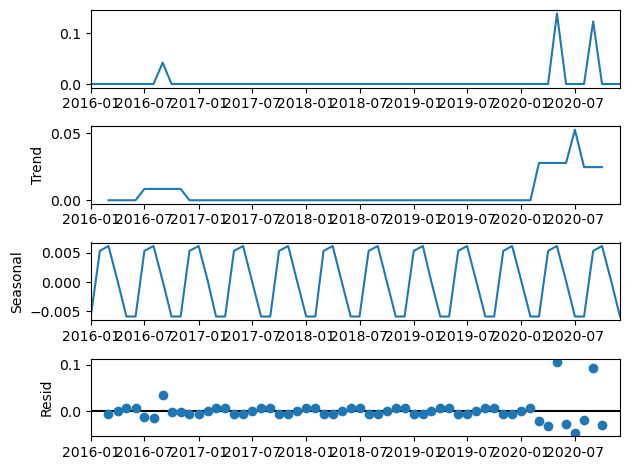

In [64]:
result.plot()
plt.show()

# Trend Analysis per District

In [44]:
#Create a dataframe that shows the fire location (district basis)
fires_per_district= gpd.sjoin(geo_fire_data, district_boundaries, how="inner", op='intersects')

#Create the right time format: we count per month per year
fires_per_district['day'] = 1
fires_per_district['year'] = pd.Series(pd.to_numeric(fires_per_district['year'], errors='coerce'), dtype='int64')
fires_per_district['month'] = pd.Series(pd.to_numeric(fires_per_district['month'], errors='coerce'), dtype='int64')
fires_per_district['ModifiedDateTime'] = pd.to_datetime(fires_per_district[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

#Sort the values based on district and time
fires_per_district_count = fires_per_district.sort_values(by=['Dist_Name', 'ModifiedDateTime'])

#Sum amount of frp (fire radiative power) per district per month per year make sure that if no fire happens at a specific time write a zero
fires_per_district_count = fires_per_district.groupby(['Dist_Name', 'Area', 'ModifiedDateTime'])['frp'].sum().unstack(fill_value=0).stack().reset_index()

#Calculate amount of frp per squared km
fires_per_district_count['frp per squared km'] = fires_per_district_count[0] / (fires_per_district_count['Area'])

#Delete column
del fires_per_district_count[0]

<ipython-input-44-09b924559bba>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires_per_district= gpd.sjoin(geo_fire_data, district_boundaries, how="inner", op='intersects')


In [45]:
#We only check the years 2016-2021
fires_per_district_count= fires_per_district_count[(fires_per_district_count['ModifiedDateTime']>='2016-01-01') & (fires_per_district_count['ModifiedDateTime']<'2021-01-01')]

In [46]:
df = pd.DataFrame({})
df.index = fires_per_district_count['ModifiedDateTime'].astype('str').unique()

In [47]:
for i in fires_per_district_count['Dist_Name'].unique():
    example_man = fires_per_district_count[fires_per_district_count['Dist_Name'] == i]
    #if len(example_man) == len(df.index):
    series = example_man[['ModifiedDateTime', 'frp per squared km']]
    series.set_index('ModifiedDateTime', inplace=True)
    result = seasonal_decompose(series, model='additive', period = 5)
    df[i] = result.resid.to_list()

In [48]:
trend_df = df.transpose().reset_index()

trend_df['geometry'] = 0
for i in range(0, len(trend_df)):
    trend_df['geometry'].iloc[i] = district_boundaries[district_boundaries['Dist_Name'] == trend_df['index'].iloc[i]]['geometry'].iloc[0]

trend_district_df = gpd.GeoDataFrame(trend_df, geometry = trend_df.geometry, crs = {'init': 'epsg:4326'}) 

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [49]:
trend_district_df.to_file('C:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\trend district FRP over time.geojson', driver="GeoJSON")  

# Create Time Series Analysis for all mandals per month per year

In [50]:
df = pd.DataFrame({})
df.index = result.trend.index

In [51]:
#adf = []
#kps = []

for i in fires_per_mandal_count['Mandal_Nam'].unique():
    example_man = fires_per_mandal_count[fires_per_mandal_count['Mandal_Nam'] == i]
    series = example_man[['ModifiedDateTime', 'frp per squared km']]
    series.set_index('ModifiedDateTime', inplace=True)
    #X = series.values
    #if sum(X)>0:
    #    adf_test = adfuller(X)
    #    kpsstest = kpss(X, regression='c', nlags="auto")
    #    adf.append(adf_test[1])
    #    kps.append(kpsstest[1])
    #else:
    #    adf.append(None)
    #    kps.append(None)
    if len(example_man) == len(df.index):
            #print('stationary p-value: %f' % adf_test[1])
        result = seasonal_decompose(series, model='additive', period = 5)
        df[i] = result.trend.to_list()

<ipython-input-51-6350b92cb13f>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = result.trend.to_list()


In [52]:
#data = {'Mandal': fires_per_mandal_count['Mandal_Nam'].unique(),
#        'adf': adf, 'kpss': kps}
 
# Create DataFrame
#df_stat = pd.DataFrame(data)

#df_stat['Stationarity'] = (df_stat['adf']<=0.05) & (df_stat['kpss']>0.05)


In [53]:
df = df.reset_index()

In [54]:
df['ModifiedDateTime'] = df['ModifiedDateTime'].astype('str')
df = df.set_index('ModifiedDateTime')

In [55]:
trend_df = df.transpose().reset_index()

In [56]:
trend_df['geometry'] = 0
for i in range(0, len(trend_df)):
    trend_df['geometry'].iloc[i] = mandal_boundaries[mandal_boundaries['Mandal_Nam'] == trend_df['index'].iloc[i]]['geometry'].iloc[0]

In [57]:
trend_df = gpd.GeoDataFrame(trend_df, geometry = trend_df.geometry, crs = {'init': 'epsg:4326'}) 

In [58]:
trend_df

ModifiedDateTime,index,2016-01-01,2016-02-01,2016-03-01,2016-04-01,2016-05-01,2016-06-01,2016-07-01,2016-08-01,2016-09-01,...,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,geometry
0,Adilabad Rural,NaN,NaN,0.000000,0.000000,0.007973,0.007973,0.007973,0.007973,0.007973,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.51587 19.74398, 78.51760 19.74352..."
1,Bazarhathnoor,NaN,NaN,0.008254,0.008254,0.008254,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.44055 19.54339, 78.44133 19.54314..."
2,Bheempoor,NaN,NaN,0.025538,0.016718,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.32724 19.88942, 78.32734 19.88928..."
3,Boath,NaN,NaN,0.000000,0.000000,0.005136,0.005136,0.005136,0.005136,0.005136,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.28576 19.44937, 78.28709 19.44884..."
4,Ichoda,NaN,NaN,0.005352,0.005352,0.006854,0.006854,0.006854,0.006854,0.006854,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.44828 19.47912, 78.45356 19.47253..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,Rajapeta,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.91859 17.80409, 78.91884 17.80393..."
484,Ramannapet,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.006696,0.006696,...,0.032599,0.011806,0.011806,0.011806,0.0,0.0,0.008018,NaN,NaN,"POLYGON ((79.24088 17.35841, 79.24038 17.35748..."
485,Turkapalle_M,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((78.86661 17.74282, 78.86688 17.74267..."
486,Valigonda,NaN,NaN,0.003885,0.003885,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010955,0.010955,0.010955,0.000000,0.0,0.0,0.000000,NaN,NaN,"POLYGON ((79.03142 17.47895, 79.03323 17.47738..."


In [59]:
trend_df.to_file('C:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\notebooks\\crop_fires\\DPPD_Jesse\\residuals FRP over time.geojson', driver="GeoJSON")  